# Lab 7: Dimensionality Reduction

In this assignment, we will learn two unsupervised learning methods: Spectral Clustering and Principal Components Analysis

## Example 1: Spectral Clustering

In this example, we synthesize a toy dataset, which has two clusters. Then, we use K-means, Agglomerative, and Spectral clustering method to partition this dataset, respectively. 

For spectral clustering method, we use two methods to construct the similarity graph. The first one is to use the K-nearest neighbor graph method, where we set $K=1$ in this example. The second method is to use the fully connected graph method, where we use the  Gaussian (aka RBF) kernel method measure the simialrity between two samples. 

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn import datasets


# generate a toy dataset with two clusters
X, y = make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=3.0, random_state=42)
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Original dataset')
plt.show()

In [ ]:
# partition the dataset with K-means
cluster_kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
centroids = cluster_kmeans.cluster_centers_  #get the clustering centroids

# partition the dataset with Agglomerative method
cluster_agg = AgglomerativeClustering(n_clusters=2).fit(X)

# partition the dataset with spectral clustering, here we use the 'nearest_neighbors' method to construct the similarity graph
cluster_sp_nn = SpectralClustering(n_clusters=2, assign_labels="discretize", affinity='nearest_neighbors', random_state=0).fit(X)

# partition the dataset with spectral clustering, here we use the 'fully connected graph' method to construct the similarity graph
cluster_sp_rbf = SpectralClustering(n_clusters=2, assign_labels="discretize", affinity='rbf', random_state=0).fit(X)


plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.scatter(X[:, 0], X[:, 1], c=cluster_kmeans.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], c=['r', 'b'])  #visualize the clustering centroids
plt.title('K-means')

plt.subplot(1,4,2)
plt.scatter(X[:, 0], X[:, 1], c=cluster_agg.labels_)
plt.title('Agglomerative method')

plt.subplot(1,4,3)
plt.scatter(X[:, 0], X[:, 1], c=cluster_sp_nn.labels_)
plt.title('Spectral clustering (nearest_neighbors)')

plt.subplot(1,4,4)
plt.scatter(X[:, 0], X[:, 1], c=cluster_sp_rbf.labels_)
plt.title('Spectral clustering (fully_connected_graph)')

plt.show()

Here, we evaluate the performance of these clustering methods with [normalized mutual information (NMI)](https://course.ccs.neu.edu/cs6140sp15/7_locality_cluster/Assignment-6/NMI.pdf)
The larger value indicates the better performance. 

In [ ]:
from sklearn.metrics.cluster import normalized_mutual_info_score


nmi_kmeans = normalized_mutual_info_score(cluster_kmeans.labels_, y, average_method='arithmetic')
nmi_agg = normalized_mutual_info_score(cluster_agg.labels_, y, average_method='arithmetic')
nmi_sp_nn = normalized_mutual_info_score(cluster_sp_nn.labels_, y, average_method='arithmetic')
nmi_sp_rbf = normalized_mutual_info_score(cluster_sp_rbf.labels_, y, average_method='arithmetic')


print('The normalized mutual information score of the K-means method is {:.4f}'.format(nmi_kmeans))
print('The normalized mutual information score of the Agglomerative method is {:.4f}'.format(nmi_agg))
print('The normalized mutual information score of the Spectral Clustering (nearest_neighbors) method is {:.4f}'.format(nmi_sp_nn))
print('The normalized mutual information score of the Spectral Clustering (fully_connected_graph) method is {:.4f}'.format(nmi_sp_rbf))

## Task 1: Spectral clustering for heart disease dataset

In this task, we use the [heart disease](heart.csv) dataset in Lab Assignment 5. 
Each sample has the following feature: 

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect




**The task is to partition all users into two groups with Spectral Clustering method.**

Then, please compare its performance with the performance of K-means and Agglomerative methods that you obtained in Lab Assignment 6.

In [ ]:
# import the necessary modules
import pandas as pd                     # for the dataframe
import matplotlib.pyplot as plt         # for plotting
import numpy as np                      # for linear algebra
from sklearn.metrics import cluster     # for normalized mutual information (NMI) score
from sklearn.cluster import\
    SpectralClustering
from math import *                      # localize mathematical functions

In [ ]:
# constants
DATASET_FILENAME = r'heart.csv'         # filename of the dataset input
P_MIN_SPARSE = 0.50                     # min rate missing for sparse features
SEED = 42                               # randomizer for sampling,
                                        # e.g., train, test data
SUPTITLE_FONTSIZE = 16                  # for figure title

In [ ]:
# load the heart disease dataset
df = pd.read_csv(DATASET_FILENAME)

# split X, y
label = df.columns[-1]                  # dataset label
yheart = df[label].values               # label vector
Xdf = df.drop(label, axis=1)            # feature dataframe

# get the # samples and dimensionality (d) of Xdf
N_SAMPS, N_FEATS = Xdf.shape
print(r"# samples = {}".format(N_SAMPS))
print(r"# features = {}".format(N_FEATS))

In [ ]:
# print some basic information about the dataset
print('\n===data frame information===')
df.info()

# print its parameters
print('\n===data frame parameters===')
df.describe()

From `df.info()`, we see that all of the features are numerical.
Additionally, there are few examples $303 \leq 1000$. So we can inspect directly.
Additionally, we see that none are missing.

Our method of inspection will be visual through the scatterplot.
We will use the target as only categorical feature,
which would serve to color the scatterplot.

In [ ]:
def tablePlot(N_FEATS, Xdf, c):
    r'''
     Creates a scatter plot table of feature pairs from the given
     number of features from Xdf, using y for the plot color.  This is
     a convenience method.
     @param N_FEATS : int = number of features to pair
     @param Xdf : pd.DataFrame = data frame from which to plot features
     @param c : scalar or array-like = of colors
     @return (fig, ax) = tuple of the figure and axes containing the
        scatter plots
     '''
    fig, ax = setupTablePlot(N_FEATS, Xdf.columns)
    ax = plotTablePlot(N_FEATS, ax, Xdf.values, c)
    return (fig, ax)
# end def (fig, ax) = tablePlot(ax, N_FEATS, Xdf, c)

def setupTablePlot(N_FEATS, Xcolumns):
    r'''
     Creates a table of subplots from the given number of features,
     labels its axes with the given column header Xcolumns.
     @param N_FEATS : int = number of features to pair
     @param Xcolumns : [str] = list of column headers for labeling axes
     @return (fig, ax) = tuple of the figure, axes containing the
        scatter plots
     '''
    # create square subplots
    # we will avoid mapping a feature to itself
    fig, ax = plt.subplots(N_FEATS - 1, N_FEATS - 1, figsize=(20, 20))

    # clear all axes
    for i_row in range(N_FEATS - 1):
        # for y for each column
        for i_col in range(N_FEATS - 1):
            ax[i_row][i_col].get_xaxis().set_visible(False)
            ax[i_row][i_col].get_yaxis().set_visible(False)
    # next i_col, i_row

    # for each row in [1, [d..2]]
    # (i_col, i_row) -> (X0, X1)
    for i_row, iX1 in enumerate([1] + list(range((N_FEATS - 1), 1, -1))):
        # calculate the number of rows
        N_COLS = (iX1 if (iX1 != 1) else N_FEATS)
        # label row
        ax[i_row][0].get_yaxis().set_label_text(Xcolumns[iX1])
        ax[i_row][0].get_yaxis().set_visible(True)
    # next iX1

    # for each column in [0, [2..N_FEATS]]
    for i_col, iX0 in enumerate([0] + list(range(2, N_FEATS))):
        # label column
        ax[0][i_col].set_title(Xcolumns[iX0])
        # for the axis, use a backwards diagonal
        ax[-i_col - 1][i_col].get_xaxis().set_visible(True)
    # next iX0

    return fig, ax
# end def (fig, ax) = setupTablePlot(N_FEATS, Xcolumns)

def plotTablePlot(N_FEATS, ax, X, c):
    r'''
     Creates a scatter plot on the table given by ax from the given
     number of features from matrix X using the given colors for each
     point.
     @param N_FEATS : int = number of features to pair
     @param ax : np.array<plt.axes> = on which to plot
     @param X : np.array = matrix from which to plot the dataset
     @param c : scalar or array-like = of colors
     @return the axes containing the scatter plots
     @see matplotlib.pyplot.scatter for @param c
     '''
    # for each row in [1, [d..2]]
    # (i_col, i_row) -> (X0, X1)
    for i_row, iX1 in enumerate([1] + list(range((N_FEATS - 1), 1, -1))):
        # get the X1 column from X
        X1 = X[:, iX1]
        # calculate the number of rows
        N_COLS = (iX1 if (iX1 != 1) else N_FEATS)
        # for each column [0, [2..N_COLS]]
        for i_col, iX0 in enumerate([0] + list(range(2, N_COLS))):
            # get the X0 column from X
            X0 = X[:, iX0]
            # plot these two features
            ax[i_row][i_col].scatter(X0, X1, c=c)
        # next iX0
    # next iX1
    return ax
# end def plotTablePlot(N_FEATS, ax, X, c)

In [ ]:
# visualize the data
tablePlot(N_FEATS, Xdf, yheart)
plt.show()

### 1.1 Preprocess the raw data

* Check whether there are missing values
* Check whether theare are cateogrical features


Earlier we found that all features are numerical. Thus, there are no categorical features.

In [ ]:
# calculate the number of missing values
n_missing = df.isnull().sum()
# calculate the rate
p_missing = n_missing/df.shape[0]

print(r'===# missing values per column===')
print(n_missing)
print()
print(r'===# missing values per column===')
print(p_missing)

# remove any sparse features
df = df.drop(df.columns[p_missing > P_MIN_SPARSE], axis = 1)

There are no missing values this time.
Let's inspect the distributions of each feature and the label.


In [ ]:
def ibqr(vector):
    r'''
     Finds the smallest nonzero inter-binary quantile range (ibqr)
     containing the interquartile range.
     @param vector = of which to find the smallest nonzero quantile
     @return (lq, uq, p) = the lower quantile, the upper quantile, the
        proportion of the data lower than the the lower quantile
     '''
    # initialize lq = uq = 0 to start the loop
    lq = 0
    uq = 0
    # proportion of the data lower than the the lower quantile
    # initialize to 0.5, which will be halved
    p = 0.5
    while (lq == uq):
        # halve the proportion
        p = p/2
        # find the quantiles for (p), (1 - p)
        lq, uq = (vector.quantile(q=q) for q in (p, (1 - p)))
    # end while (iqr == 0)
    return (lq, uq, p)
# end def ibqr(vector)

# loop through the features (all numerical)
for column in df.columns:
    # find the range
    min_val = df[column].min()
    max_val = df[column].max()
    range_val = max_val - min_val
    # find the smallest nonzero inter-binary quantile range
    (lq, uq, p) = ibqr(df[column])
    ibqr_val = uq - lq
    # estimate a nonzero interquartile range
    iqr = ibqr_val/(2 - 4*p)
    # calculate the bin width
    # using Freedman–Diaconis' choice
    n = df[column].shape[0]
    width = (2 * iqr * (n**(-1/3)))
    # calculate the number of bins
    n_bins = ceil(range_val/width)
    # end if (iqr)
    
    # print the parameters we calculated
    print(fr"===histogram of {column}===")
    print('min\t', min_val)
    print("{}%\t {}".format(100*p, lq))
    print("{}%\t {}".format(100*(1 - p), uq))
    print('ibqr\t', ibqr_val)
    print('iqr\t', ('~' if (ibqr_val != iqr) else ' '), iqr, sep='')
    print('max\t', max_val)
    print('range\t', range_val)
    print('width\t', width)
    print('# bins\t', n_bins)

    # plot for this feature
    plt.hist(df[column].values, n_bins)
    # place the plot here
    plt.show()
    print()
# next column

This time,
we had to handle at least $1$ case of $\operatorname{IQR} = 0$
in the case of `[5]` fasting blood sugar.
In that case,
I expanded to a $50\,\%$ larger nonZERO interquantile of $\left[25\,\%,75\,\%\right]$ with a range of $1$,
and scaled the range by $\frac{1}{\left(1 + 0.50\right)^1} = \frac{2}{3}$,
replacing the $\operatorname{IQR}$.
From this, I proceeded to calculate the bin width.

We can see that
* `[0]` age, `[3]` resting BPS, `[4]` cholesterol,
  `[5]` fasting blood sugar, `[7]` maximum `thal` achieved,
  `[9]` `oldpeak`, `[11]` number of major vessel, and [12] `thal`.
  are long-tail distributions.
* `[1]` sex, `[2]` chest pain, `[6]` resting ECG,
  `[8]` exercise-induced angina, `[10]` slope of peak, and the label
  `[13]` `target` are non-long tail distributions.

In [ ]:
cols = df.columns
# all numerical columns
i_cols = set(range(cols.shape[0]))

# We can see that:
# * `[1]` sex, `[2]` chest pain, `[6]` resting ECG,
#   `[8]` exercise-induced angina, `[10]` slope of peak, and the label
#   `[13]` `target` are non-long tail distributions.
i_longtails = [1, 2, 6, 8, 10, 13]
# * `[0]` age, `[3]` resting BPS, `[4]` cholesterol,
#   `[5]` fasting blood sugar, `[7]` maximum `thal` achieved,
#   `[9]` `oldpeak`, `[11]` number of major vessel, and [12] `thal`.
i_non_longtails = list(i_cols - set(i_longtails))

# split the long tail distributions and non-long tail distributions
df_longtail_cols = cols[list(i_longtails)]
df_non_longtail_cols = cols[i_non_longtails]

# print the distribution by type
print(r'===columns by distribution===')
print(r"long tails: {}".format(df_longtail_cols))
print(r"non-long tails: {}".format(df_non_longtail_cols))

# replace missing long tails with medians
for column in df_longtail_cols:
    median = df[column].median()
    df[column] = df[column].fillna(median)
# next lt_column in df_longtail_cols

# for missing non-long tails, replace with mean
for column in df_non_longtail_cols:
    mean = df[column].mean()
    df[column] = df[column].fillna(mean)
# next column in df_non_longtail_cols

# confirm that there are no missing values
print(r'===Any still missing?===')
print(df.isna().sum() != 0)

We check the correlations of each pair of features to find redundant features that can be eliminited.

In [ ]:
# calculate the correlation matrix
hcorr = df.corr()
# display using gradients
hcorr.style.background_gradient()

In [ ]:
print(r"max{{r^2}} = {}".format((-0.577537)**2))

There is no strong correlation between any pair of features.
(The highest $r^2 = (-0.577537)^2 = 0.333548986369$ between `oldpeak` and the slope of peak.)

To see if target will be balanced, let us view it more clearly using the bar plot.

In [ ]:
# find the label and its label counts
label = df.columns[-1]
label_counts = df[label].value_counts()
r_diff = 2*abs(label_counts[0] - label_counts[1])/(label_counts[0] + label_counts[1])

# print and bar plot of the label
print(label)
print(label_counts)
print(r"rate of difference = {}".format(r_diff))
label_counts.plot(kind=r'bar')
plt.show()

The relative rate of difference is about $17.8\,\%$, which is significant. Thus, the data is somewhat imbalanced.

Let's split the post processed data.

In [ ]:
# split X, y after post processing
yheart = df[label].values               # label vector
Xdf = df.drop(label, axis=1)            # feature dataframe

### 1.2 Partition the dataset with Spectral Clustering and compute its NMI
Please use K-nearest neighbor graph method and fully connected graph method to build the similarity graph, respectively. Compare their clustering performance by visualization and computing NMI. 

In [ ]:
# partition the dataset spectral clustering
# first find number of clusters
yset = np.unique(yheart)

# using nearest_neighbors
affinity=r'nearest_neighbors'
cluster_knn = SpectralClustering(
    n_clusters=len(yset),
    assign_labels=r'discretize',
    affinity=affinity,
    random_state=SEED
).fit(Xdf)

# using fully connected graph
affinity='rbf'
cluster_fully_connected = SpectralClustering(
    n_clusters=len(yset),
    assign_labels=r'discretize',
    affinity=affinity,
    random_state=SEED
).fit(Xdf)

# compute their NMIs
nmi_knn = cluster.normalized_mutual_info_score(
    cluster_knn.labels_, yheart, average_method='arithmetic'
)
nmi_fully_connected = cluster.normalized_mutual_info_score(
    cluster_fully_connected.labels_, yheart, average_method='arithmetic'
)

print(r'===K-nearest neighbors===')
print("NMI\t{:.4e}".format(nmi_knn))
print(r'===fully connected graph===')
print("NMI\t{:.4e}".format(nmi_fully_connected))

In [ ]:
# plot the similarity graph with the labels from the Knn
(fig_knn, _) = tablePlot(N_FEATS, Xdf, cluster_knn.labels_)
fig_knn.suptitle(
    'Spectral clustering using $K$-nearest neighbors',
    fontsize=SUPTITLE_FONTSIZE
)
plt.show()

# plot the similarity graph with the labels from the fully connected
# graph
(fig_fully_connected, _) = tablePlot(N_FEATS, Xdf, cluster_fully_connected.labels_)
fig_fully_connected.suptitle(
    'Spectral clustering using fully connected graph',
    fontsize=SUPTITLE_FONTSIZE
)
plt.show()

## Example 2: Principal Component Analysis

In this example, we will show how to use PCA to reduce the dimensionality of the dataset. 

Here, we use the [iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). It is a classification dataset. Each sample has 4 features. In this example, we will use PCA to reduce the number of features from 4 to 2, and then visualize this new dataset in 2D space. 

In [ ]:
from sklearn import datasets
from sklearn.decomposition import PCA
import numpy as np

# load dataset, which has 3 classes
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

print('number of original features: {}'.format(X.shape[1]))

#centering the data
X -= np.mean(X, axis = 0)  

# pca, reduce the number of features from 4 to 2
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

print('number of new features: {}'.format(X_r.shape[1]))


# visualization
plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

In the following, we will apply Kmeans method to this dataset. In particular, we will apply Kmeans to the original data and the dimensionality-reduced data. 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score


# partition the original dataset with K-means
cluster_original = KMeans(n_clusters=2, random_state=0).fit(X)
centroids = cluster_kmeans.cluster_centers_  #get the clustering centroids

# partition the dimensionality-reduced dataset with K-means
cluster_pca = KMeans(n_clusters=2, random_state=0).fit(X_r)
centroids = cluster_kmeans.cluster_centers_  #get the clustering centroids

#evaluate the clustering performance
nmi_original = normalized_mutual_info_score(cluster_original.labels_, y, average_method='arithmetic')
nmi_pca = normalized_mutual_info_score(cluster_pca.labels_, y, average_method='arithmetic')

print('The normalized mutual information score of the original dataset is {:.4f}'.format(nmi_original))
print('The normalized mutual information score of the dimensionality-reduced dataset is {:.4f}'.format(nmi_pca))


From the clustering performance, we can see that they have almost the same clustering performance, which means that PCA keeps almost all the information in the original data. 

## Task 2: PCA for  heart disease dataset

In this experiment, we still use the [heart disease](heart.csv) dataset in Lab Assignment 5. 
Each sample has the following feature: 

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

This dataset has a lot of features. In this experiment, we will use PCA method to reduce the dimensionality of the original data, and then we apply the Logistic regression model to the dimensionality-reduced data to do classification. 

In [1]:
# import the necessary modules
import pandas as pd                     # for the dataframe
import matplotlib.pyplot as plt         # for plotting
import numpy as np                      # for linear algebra
from sklearn import decomposition       # for PCA decomposition
from sklearn.model_selection import\
    train_test_split
from math import *                      # localize mathematical functions

In [2]:
# constants
DATASET_FILENAME = r'heart.csv'         # filename of the dataset input
P_MIN_SPARSE = 0.50                     # min rate missing for sparse features
SEED = 42                               # randomizer for sampling,
                                        # e.g., train, test data
P_TESTING = 0.2                         # rate of training data

In [3]:
# load the heart disease dataset
df = pd.read_csv(DATASET_FILENAME)

# split X, y
label = df.columns[-1]                  # dataset label
yheart = df[label].values               # label vector
Xdf = df.drop(label, axis=1)            # feature dataframe

# get the # samples and dimensionality (d) of Xdf
N_SAMPS, N_FEATS = Xdf.shape
print(r"# samples = {}".format(N_SAMPS))
print(r"# features = {}".format(N_FEATS))

# samples = 303
# features = 13


Please see [Task 1](#Task-1:-Spectral-clustering-for-heart-disease-dataset) for the inspection and visualization of the original dataset.

### 2.1 Preprocess the raw data

* Check whether there are missing values
* Check whether theare are cateogrical features
* $\color{red}{Centering\ the\ data}$


Earlier we found that all features are numerical. Thus, there are no categorical features.

In [4]:
# calculate the number of missing values
n_missing = df.isnull().sum()
# calculate the rate
p_missing = n_missing/df.shape[0]

print(r'===# missing values per column===')
print(n_missing)
print()
print(r'===# missing values per column===')
print(p_missing)

# remove any sparse features
df = df.drop(df.columns[p_missing > P_MIN_SPARSE], axis = 1)

===# missing values per column===
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

===# missing values per column===
age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64


There are no missing values this time.
In [Task 1.1](#1.1-Preprocess-the-raw-data), we inspected the distributions of each feature and the label.


We had to handle at least $1$ case of $\operatorname{IQR} = 0$
in the case of `[5]` fasting blood sugar.
In that case,
I expanded to a $50\,\%$ larger nonZERO interquantile of $\left[25\,\%,75\,\%\right]$ with a range of $1$,
and scaled the range by $\frac{1}{\left(1 + 0.50\right)^1} = \frac{2}{3}$,
replacing the $\operatorname{IQR}$.
From this, I proceeded to calculate the bin width.

We saw that
* `[0]` age, `[3]` resting BPS, `[4]` cholesterol,
  `[5]` fasting blood sugar, `[7]` maximum `thal` achieved,
  `[9]` `oldpeak`, `[11]` number of major vessel, and [12] `thal`.
  are long-tail distributions.
* `[1]` sex, `[2]` chest pain, `[6]` resting ECG,
  `[8]` exercise-induced angina, `[10]` slope of peak, and the label
  `[13]` `target` are non-long tail distributions.

In [5]:
cols = df.columns
# all numerical columns
i_cols = set(range(cols.shape[0]))

# We can see that:
# * `[1]` sex, `[2]` chest pain, `[6]` resting ECG,
#   `[8]` exercise-induced angina, `[10]` slope of peak, and the label
#   `[13]` `target` are non-long tail distributions.
i_longtails = [1, 2, 6, 8, 10, 13]
# * `[0]` age, `[3]` resting BPS, `[4]` cholesterol,
#   `[5]` fasting blood sugar, `[7]` maximum `thal` achieved,
#   `[9]` `oldpeak`, `[11]` number of major vessel, and [12] `thal`.
i_non_longtails = list(i_cols - set(i_longtails))

# split the long tail distributions and non-long tail distributions
df_longtail_cols = cols[list(i_longtails)]
df_non_longtail_cols = cols[i_non_longtails]

# print the distribution by type
print(r'===columns by distribution===')
print(r"long tails: {}".format(df_longtail_cols))
print(r"non-long tails: {}".format(df_non_longtail_cols))

# replace missing long tails with medians
for column in df_longtail_cols:
    median = df[column].median()
    df[column] = df[column].fillna(median)
# next lt_column in df_longtail_cols

# for missing non-long tails, replace with mean
for column in df_non_longtail_cols:
    mean = df[column].mean()
    df[column] = df[column].fillna(mean)
# next column in df_non_longtail_cols

# confirm that there are no missing values
print(r'===Any still missing?===')
print(df.isna().sum() != 0)

===columns by distribution===
long tails: Index(['sex', 'cp', 'restecg', 'exang', 'slope', 'target'], dtype='object')
non-long tails: Index(['age', 'trestbps', 'chol', 'fbs', 'thalach', 'oldpeak', 'ca', 'thal'], dtype='object')
===Any still missing?===
age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool


We check the correlations of each pair of features to find redundant features that can be eliminited.

In [6]:
# calculate the correlation matrix
hcorr = df.corr()
# display using gradients
hcorr.style.background_gradient()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


In [7]:
print(r"max{{r^2}} = {}".format((-0.577537)**2))

max{r^2} = 0.333548986369


There is no strong correlation between any pair of features.
(The highest $r^2 = (-0.577537)^2 = 0.333548986369$ between `oldpeak` and the slope of peak.)

To see if target will be balanced, let us view it more clearly using the bar plot.

target
1    165
0    138
Name: target, dtype: int64
rate of difference = 0.1782178217821782


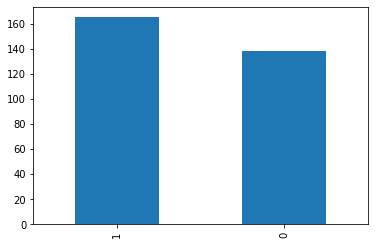

In [8]:
# find the label and its label counts
label = df.columns[-1]
label_counts = df[label].value_counts()
r_diff = 2*abs(label_counts[0] - label_counts[1])/(label_counts[0] + label_counts[1])

# print and bar plot of the label
print(label)
print(label_counts)
print(r"rate of difference = {}".format(r_diff))
label_counts.plot(kind=r'bar')
plt.show()

The relative rate of difference is about $17.8\,\%$, which is significant. Thus, the data is somewhat imbalanced.

Let's split the post processed data.


In [9]:
# split X, y after post processing
yheart = df[label].values               # label vector
Xdf = df.drop(label, axis=1)            # feature dataframe

#### $\color{red}{\textit{Centering the data}}$

To center the data, we simply subtract by the mean for each feature.

In [10]:
# find the means
means = np.mean(Xdf, axis=0)
# subtract
Xdf = (Xdf - means)

# table the statistics to verify normalization
print('\n===data frame stats===')
Xdf.describe()


===data frame stats===


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,303.000000,3.030000e+02,3.030000e+02,3.030000e+02
mean,5.628061e-16,-5.862564e-17,-1.876020e-16,-1.275694e-14,-7.785485e-15,2.931282e-18,4.396923e-17,-1.425776e-14,-2.345026e-17,0.000000,-5.862564e-17,-4.690051e-17,-1.407015e-16
std,9.082101e+00,4.660108e-01,1.032052e+00,1.753814e+01,5.183075e+01,3.561979e-01,5.258596e-01,2.290516e+01,4.697945e-01,1.161075,6.162261e-01,1.022606e+00,6.122765e-01
min,-2.536634e+01,-6.831683e-01,-9.669967e-01,-3.762376e+01,-1.202640e+02,-1.485149e-01,-5.280528e-01,-7.864686e+01,-3.267327e-01,-1.039604,-1.399340e+00,-7.293729e-01,-2.313531e+00
25%,-6.866337e+00,-6.831683e-01,-9.669967e-01,-1.162376e+01,-3.526403e+01,-1.485149e-01,-5.280528e-01,-1.614686e+01,-3.267327e-01,-1.039604,-3.993399e-01,-7.293729e-01,-3.135314e-01
50%,6.336634e-01,3.168317e-01,3.300330e-02,-1.623762e+00,-6.264026e+00,-1.485149e-01,4.719472e-01,3.353135e+00,-3.267327e-01,-0.239604,-3.993399e-01,-7.293729e-01,-3.135314e-01
75%,6.633663e+00,3.168317e-01,1.033003e+00,8.376238e+00,2.823597e+01,-1.485149e-01,4.719472e-01,1.635314e+01,6.732673e-01,0.560396,6.006601e-01,2.706271e-01,6.864686e-01
max,2.263366e+01,3.168317e-01,2.033003e+00,6.837624e+01,3.177360e+02,8.514851e-01,1.471947e+00,5.235314e+01,6.732673e-01,5.160396,6.006601e-01,3.270627e+00,6.864686e-01


Now we find that `mean`$\approx 0$ for all features.
This should be the case for centered data.

### 2.2 Use PCA to do dimensionality reduction for visualization

* Please reduce the number of features to 2 and visualize this dataset by following the given example.


In [11]:
# create the PCA decomposition
n_features_goal = 2
pca = decomposition.PCA(n_components=n_features_goal)
# reduce this in Xdf
X_r = pca.fit(Xdf).transform(Xdf)

# get the # samples and dimensionality (d) of X_r
N_SAMPS_R, N_FEATS_R = X_r.shape
print(r"# samples after dimensionality reduction = {}".format(N_SAMPS_R))
print(r"# features after dimensionality reduction = {}".format(N_FEATS_R))

# samples after dimensionality reduction = 303
# features after dimensionality reduction = 2


Finally, let's visualize the result.

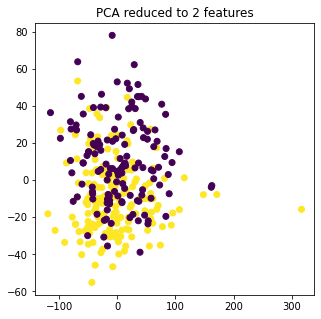

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(X_r[:, 0], X_r[:, 1], c=yheart)
plt.title("PCA reduced to {} features".format(N_FEATS_R))
plt.show()

### 2.3 Use PCA to do dimensionality reduction and then conduct classification

* Please reduce the number of features to different values (e.g. 2, 5, 10)
* Then, please run logistic regression model with the dimensionality-reduced data.
* Compare the classification performance (e.g. accuracy, F1-score) when using different number of features(e.g. 2, 5, 10). 


The data is already preprocessed up until, but excluding the normalization.

To normalize, first check for outliers, defined as any value $1.5 \operatorname{IQR}$s outside of the range $\left[Q_1, Q_3\right]$.

In [14]:
def checkForOutliers(df, PRINT_ONLY_RESULT=False):
    r'''
     Performs a verbose check for outliers.
     @param df : pd.DataFrame = to check
     @param PRINT_ONLY_RESULT : bool = whether to print only the
        unlabeled result (no intermediate steps)
     @return array of the index of outliers
     '''
    # find the interquartile range
    q1 = df.quantile(q=0.25)
    q3 = df.quantile(q=0.75)
    iqr = q3 - q1
    # calculate the limits of the outlier
    inlier_min = (q1 - 1.5*iqr)
    inlier_max = (q3 + 1.5*iqr)
    # find any values out of range
    outliers = ((df < inlier_min) | (df > inlier_max))
    # print the results
    if (not(PRINT_ONLY_RESULT)):
        print(r'===inlier lower limit===')
        print(inlier_min)
        print()
        print(r'===inlier upper limit===')
        print(inlier_max)
        print()
        print(r'===has outliers?===')
    # end if (!PRINT_ONLY_RESULT)
    print(outliers.any())
    return outliers
# def checkForOutliers

Let's test it on the original dataframe.

In [15]:
_ = checkForOutliers(df)

===inlier lower limit===
age          27.25
sex          -1.50
cp           -3.00
trestbps     90.00
chol        115.75
fbs           0.00
restecg      -1.50
thalach      84.75
exang        -1.50
oldpeak      -2.40
slope        -0.50
ca           -1.50
thal          0.50
target       -1.50
dtype: float64

===inlier upper limit===
age          81.25
sex           2.50
cp            5.00
trestbps    170.00
chol        369.75
fbs           0.00
restecg       2.50
thalach     214.75
exang         2.50
oldpeak       4.00
slope         3.50
ca            2.50
thal          4.50
target        2.50
dtype: float64

===has outliers?===
age         False
sex         False
cp          False
trestbps     True
chol         True
fbs          True
restecg     False
thalach      True
exang       False
oldpeak      True
slope       False
ca           True
thal         True
target      False
dtype: bool


We can see outliers in `[3]` resting BPS, `[4]` cholesterol, `[5]` fasting blood sugar, `[7]` maximum thal achieved, `[9]` oldpeak, `[11]` number of major vessel, and `[12]` `thal`.
Since at least one column has outliers,
we should use standardization (Z-score normalization),
rather than min-max normalization,
which is sensitive to outliers.

Now let's try every reduction.

In [18]:
X_rs = []
# loop through [1, d] (reduced # features)
for iX_r in range(0, (N_FEATS - 1)):
    # perform and store the reduction
    pca = decomposition.PCA(n_components=(iX_r + 1))
    X_rs.append(pca.fit(Xdf).transform(Xdf))
    # convert to dataframe
    X_rs[-1] = pd.DataFrame(X_rs[-1])
    # check for outliers
    print("===reduced to {}, has outliers?===".format(iX_r))
    checkForOutliers(X_rs[iX_r], PRINT_ONLY_RESULT=True)
# next iX_r

===reduced to 0, has outliers?===
0    True
dtype: bool
===reduced to 1, has outliers?===
0    True
1    True
dtype: bool
===reduced to 2, has outliers?===
0    True
1    True
2    True
dtype: bool
===reduced to 3, has outliers?===
0    True
1    True
2    True
3    True
dtype: bool
===reduced to 4, has outliers?===
0    True
1    True
2    True
3    True
4    True
dtype: bool
===reduced to 5, has outliers?===
0    True
1    True
2    True
3    True
4    True
5    True
dtype: bool
===reduced to 6, has outliers?===
0    True
1    True
2    True
3    True
4    True
5    True
6    True
dtype: bool
===reduced to 7, has outliers?===
0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
dtype: bool
===reduced to 8, has outliers?===
0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
dtype: bool
===reduced to 9, has outliers?===
0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
dt

Well, we must split into train and test data and normalize.
Additionally, note that every feature at every reduction contains outliers.
Thus standardization is preferable for normalization.

In [25]:
# training data (standardized)
Z_trains = []
y_trains = []
# testing data (standardized)
Z_tests = []
y_tests = []

# for each feature-reduced dataset
for iX_r in range(0, (N_FEATS - 1)):
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_rs[iX_r], yheart, test_size=P_TESTING, random_state=SEED)
    # standardization
    means = np.mean(X_train, axis=0)
    stds = np.std(X_train, axis=0)
    Z_trains.append((X_train - means)/stds)
    Z_tests.append((X_test - means)/stds)
    # convert Z-scores to dataframes
    Z_trains[-1] = pd.DataFrame(Z_trains[-1])
    Z_tests[-1] = pd.DataFrame(Z_tests[-1])
    # copy y's
    y_trains.append(y_train)
    y_tests.append(y_test)

    # print the statistics to verify normalization
    print("===reduced to {}, data frame stats?===".format(iX_r))
    print(Z_trains[-1].describe())
# next iX_r

===reduced to 0, data frame stats?===
                  0
count  2.420000e+02
mean  -1.468064e-17
std    1.002073e+00
min   -2.183481e+00
25%   -6.668805e-01
50%   -1.457385e-01
75%    5.397827e-01
max    5.989961e+00
===reduced to 1, data frame stats?===
                  0             1
count  2.420000e+02  2.420000e+02
mean   1.468064e-17 -4.771206e-17
std    1.002073e+00  1.002073e+00
min   -2.183481e+00 -2.403921e+00
25%   -6.668805e-01 -7.412053e-01
50%   -1.457385e-01 -1.589945e-01
75%    5.397827e-01  6.988665e-01
max    5.989961e+00  2.839379e+00
===reduced to 2, data frame stats?===
                  0             1             2
count  2.420000e+02  2.420000e+02  2.420000e+02
mean   1.468064e-17 -4.771206e-17  2.202095e-17
std    1.002073e+00  1.002073e+00  1.002073e+00
min   -2.183481e+00 -2.403921e+00 -2.074344e+00
25%   -6.668805e-01 -7.412053e-01 -6.827144e-01
50%   -1.457385e-01 -1.589945e-01 -9.442097e-02
75%    5.397827e-01  6.988665e-01  6.206568e-01
max    5.989961e

Now we find that `mean`$\approx 0$ and `std`$\approx 1$ for all features.
This should be the case for standardized data.

In [ ]:
# your code